In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pickle

df = pd.read_csv("Clean_Data.csv")
df.sample(10)

TRAIN = True

## Predicting Readmission Within 30 days

In [2]:
X = df.drop(['readmitted','within30'],axis=1)
y = df['within30']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=5)
y_test.value_counts()

0    19168
1      939
Name: within30, dtype: int64

In [3]:
y_train.value_counts()

0    44691
1     2225
Name: within30, dtype: int64

Let us try a logistic regression as our baseline model.

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import scikitplot as skplt 
import matplotlib.pyplot as plt

def compute_precision(tp, fp):
    return tp / (tp + fp)

def compute_recall(tp, fn):
    return tp / (tp + fn)

def conf_metrics(y_test,y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    conf_mat = confusion_matrix(y_test, y_pred)
    print(conf_mat)
    tn, fp, fn, tp = conf_mat.ravel()
    print("True Negatives: ",tn)
    print("False Positives: ",fp)
    print("False Negatives: ",fn)
    print("True Positives: ",tp)
    precision = compute_precision(tp, fp)
    recall = compute_recall(tp, fn)
    print('Precision: {0:.2f}\nRecall: {1:.2f}'.format(precision, recall))

def plot_roc_auc(model,X_test,y_test):
    y_pred_proba = model.predict_proba(X_test)
    skplt.metrics.plot_roc(y_test, y_pred_proba)
    plt.show()

Accuracy: 95.31%
[[19158    10]
 [  934     5]]
True Negatives:  19158
False Positives:  10
False Negatives:  934
True Positives:  5
Precision: 0.33
Recall: 0.01


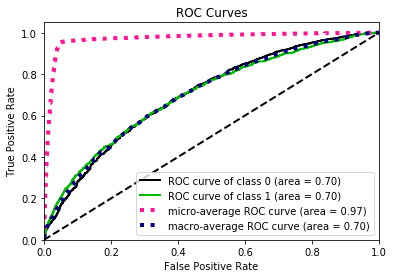

In [15]:
# Version 0 without any parameters
logReg0 = LogisticRegression(solver='liblinear',max_iter=1000, random_state=5).fit(X_train, y_train)
y_pred_lr0 = logReg0.predict(X_test)
conf_metrics(y_test,y_pred_lr0)
plot_roc_auc(logReg0,X_test,y_test)

Accuracy: 73.61%
[[14279  4889]
 [  418   521]]
True Negatives:  14279
False Positives:  4889
False Negatives:  418
True Positives:  521
Precision: 0.10
Recall: 0.55


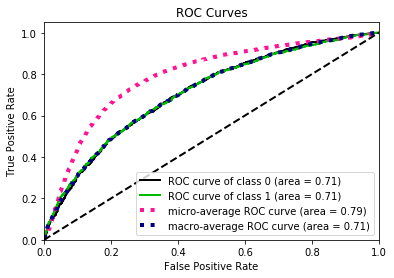

In [16]:
# Version 1 with class_weight
logReg1 = LogisticRegression(solver='liblinear',max_iter=1000, random_state=5,class_weight={0:1,1:18}).fit(X_train, y_train)
y_pred_lr1 = logReg1.predict(X_test)
conf_metrics(y_test, y_pred_lr1)
plot_roc_auc(logReg1,X_test,y_test)

Accuracy: 69.90%
[[13458  5710]
 [  343   596]]
True Negatives:  13458
False Positives:  5710
False Negatives:  343
True Positives:  596
Precision: 0.09
Recall: 0.63


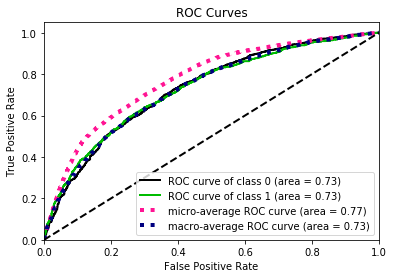

In [17]:
#import XGBoost classifier and accuracy
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

#instantiate model and train
if TRAIN:
    model1 = XGBClassifier(scale_pos_weight=20)
    model1.fit(X_train, y_train)
    pickle.dump(model1, open("model1.pickle.dat", "wb"))
else:
    model1 = pickle.load(open("model1.pickle.dat", "rb"))

# make predictions for test set
y_pred1 = model1.predict(X_test)

conf_metrics(y_test, y_pred1)
plot_roc_auc(model1, X_test, y_test)

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.08')

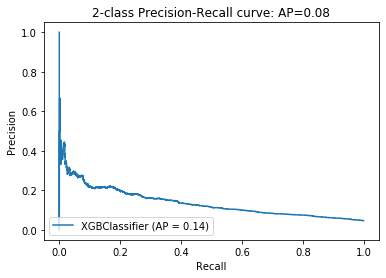

In [18]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score

average_precision = average_precision_score(y_test, y_pred1)
disp = plot_precision_recall_curve(model1, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

In [19]:
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 5) 
X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)
y_train_smote.value_counts()

1    44691
0    44691
Name: within30, dtype: int64

Trying SMOTE might help in the case of imbalanced datasets like fraud detection where the number of occurrences of fraud is extremely low compared to the data available. 

Accuracy: 94.68%
[[19012   156]
 [  914    25]]
True Negatives:  19012
False Positives:  156
False Negatives:  914
True Positives:  25
Precision: 0.14
Recall: 0.03


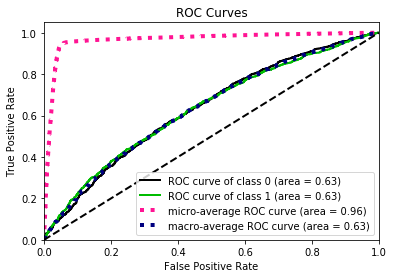

In [20]:
#instantiate model and train
if TRAIN:
    model2 = XGBClassifier()
    model2.fit(X_train_smote, y_train_smote)
    pickle.dump(model2, open("model2.pickle.dat", "wb"))
else:
    model2 = pickle.load(open("model2.pickle.dat", "rb"))

# make predictions for test set
y_pred2 = model2.predict(X_test)

conf_metrics(y_test, y_pred2)
plot_roc_auc(model2, X_test, y_test)

Not preferred as the main aim here is to detect true positives and the confusion matrix obtained is really bad! It seems like we would get better performance by trying to use XGBoost parameters for dealing with class imbalance.

## Predicting Readmission (No time period) -- More like risk/condition

In [21]:
y = df['readmitted']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=5)
y_test.value_counts()

0    15105
1     5002
Name: readmitted, dtype: int64

In [22]:
y_train.value_counts()

0    35153
1    11763
Name: readmitted, dtype: int64

Accuracy: 64.50%
[[9859 5246]
 [1891 3111]]
True Negatives:  9859
False Positives:  5246
False Negatives:  1891
True Positives:  3111
Precision: 0.37
Recall: 0.62


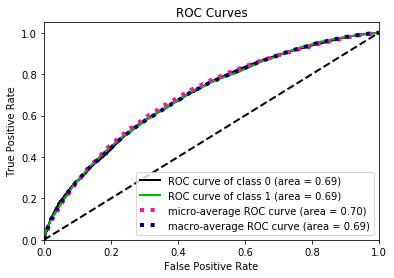

In [24]:
# Logistic Regression for Long term risk
logReg2 = LogisticRegression(solver='liblinear',max_iter=1000, random_state=5,class_weight={0:1,1:3}).fit(X_train, y_train)
y_pred_lr2 = logReg2.predict(X_test)
conf_metrics(y_test, y_pred_lr2)
plot_roc_auc(logReg2, X_test, y_test)

Accuracy: 66.65%
[[10308  4797]
 [ 1909  3093]]
True Negatives:  10308
False Positives:  4797
False Negatives:  1909
True Positives:  3093
Precision: 0.39
Recall: 0.62


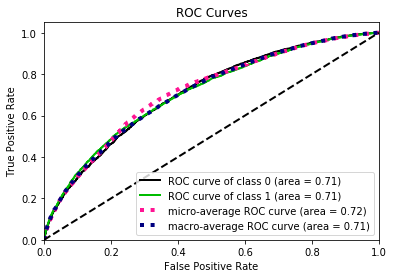

In [25]:
# XGBoost for Long term risk
if TRAIN:
    model3 = XGBClassifier(scale_pos_weight=3)
    model3.fit(X_train, y_train)
    pickle.dump(model3, open("model3.pickle.dat", "wb"))
else:
    model3 = pickle.load(open("model3.pickle.dat", "rb"))

# make predictions for test set
y_pred3 = model3.predict(X_test)

conf_metrics(y_test, y_pred3)
plot_roc_auc(model3, X_test, y_test)

## Model Explainability

In [26]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model1, random_state=5).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

C:\Users\sangh\Miniconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\sangh\Miniconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Weight,Feature
0.0810 ± 0.0049,number_inpatient
0.0512 ± 0.0029,total_admissions
0.0080 ± 0.0021,admission_type_id_6
0.0060 ± 0.0008,admission_type_id_5
0.0035 ± 0.0002,discharge_disposition_id_25
0.0021 ± 0.0012,number_outpatient
0.0020 ± 0.0007,discharge_disposition_id_13
0.0016 ± 0.0007,discharge_disposition_id_18
0.0012 ± 0.0007,diabetesMed
0.0006 ± 0.0016,num_lab_procedures


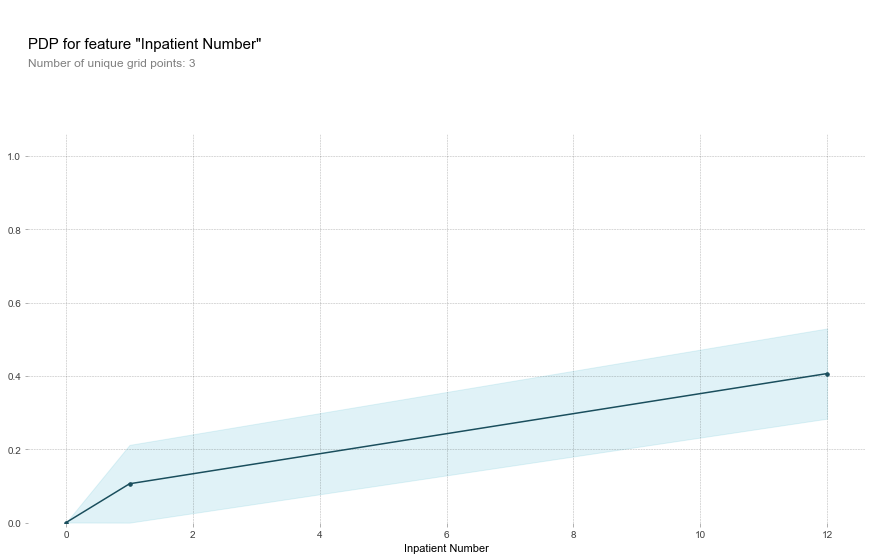

In [27]:
from pdpbox import pdp, get_dataset, info_plots

feature_names = X_test.columns.tolist()
pdp_goals = pdp.pdp_isolate(model=model1, dataset=X_test, model_features=feature_names, feature='number_inpatient')
pdp.pdp_plot(pdp_goals, 'Inpatient Number')
plt.show()

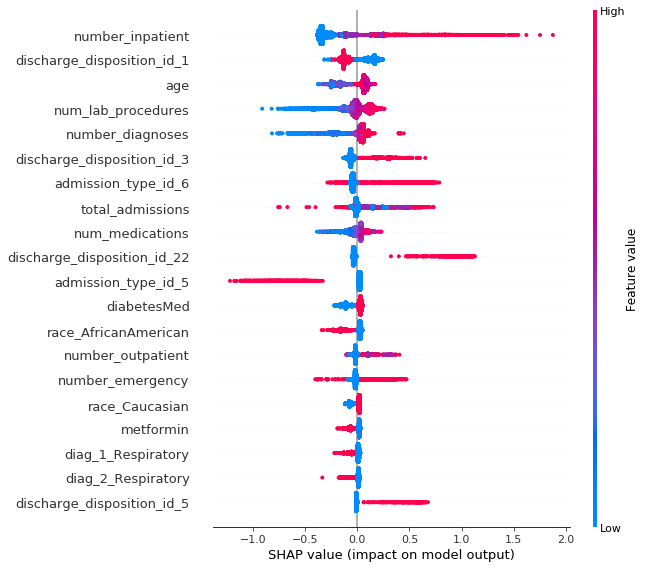

In [28]:
import shap
explainer = shap.TreeExplainer(model1)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

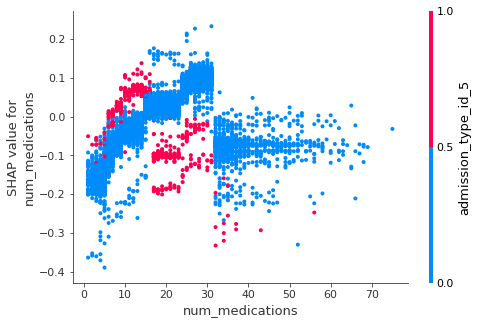

In [29]:
shap.dependence_plot('num_medications', shap_values, X_test)

### Explainability for individual patients

In [30]:
test_row = X_test.iloc[10]
shap_values = explainer.shap_values(test_row)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, test_row)